<a href="https://colab.research.google.com/github/superasymmetry/CPSY1291_finalproject/blob/main/CPSY1291_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.17.

ERROR: Invalid requirement: 'tensorflow==2.17.': Expected end or semicolon (after version specifier)
    tensorflow==2.17.
              ~~~~~~^


In [ ]:
import tensorflow as tf
import scipy.fftpack as fp
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


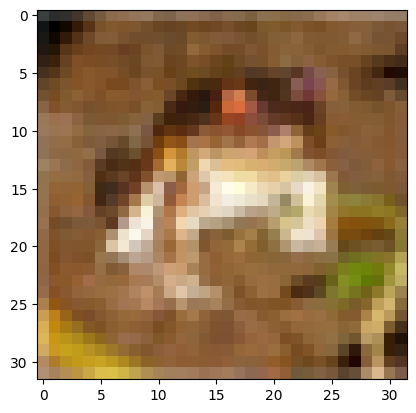

/tmp/ipython-input-2672651239.py:13: RuntimeWarning: Mean of empty slice.
  f = lambda r : processed[(R >= r-0.5) & (R < r+0.5)].mean()
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2480: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


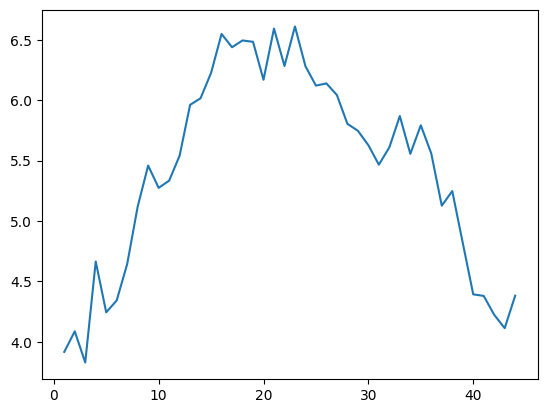

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
img = x_train[0]
plt.imshow(img)
plt.show()

transformed = fp.fft(fp.fft(img, axis=0), axis=1)
centered = fp.fftshift(transformed)
processed = np.log(abs(centered) + 1e-8)

x,y = np.meshgrid(np.arange(processed.shape[1]),np.arange(processed.shape[0]))
R = np.sqrt(x**2+y**2)

f = lambda r : processed[(R >= r-0.5) & (R < r+0.5)].mean()
r  = np.linspace(1,50,num=50)
mean = np.vectorize(f)(r)

fig,ax=plt.subplots()
ax.plot(r,mean)
plt.show()

In [ ]:
!pip install datasets==3.6.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


##Remove frequencies

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

imagenette.py: 0.00B [00:00, ?B/s]

320px/train/0000.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

320px/validation/0000.parquet:   0%|          | 0.00/103M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

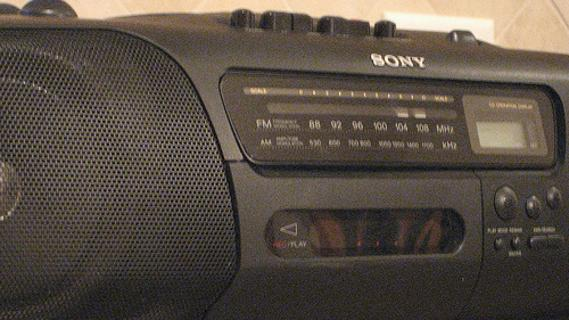

In [ ]:
from datasets import load_dataset

ds = load_dataset("frgfm/imagenette", "320px")

image = ds["train"][0]["image"]
image

(320, 632)


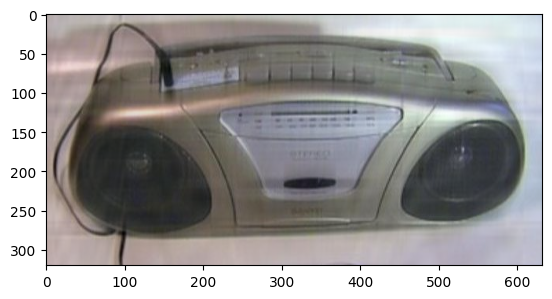

In [ ]:
image_data = np.array(image)
image_red = image_data[:,:,0]
print(image_red.shape)
image_green = image_data[:,:,1]
image_blue = image_data[:,:,2]

def remove_freqs(img_data, threshold):
  image_fft = fp.fft2(img_data)

  rows, cols = img_data.shape
  freq_x = fp.fftfreq(cols)
  freq_y = fp.fftfreq(rows)

  for i in range(len(freq_x)):
    for j in range(len(freq_y)):
      if freq_x[i] > threshold and freq_y[j] > threshold:
        image_fft[i][j] = 0.0
        # image_fft[rows - i][cols - j] = 0.0
        # image_fft[rows - i][j] = 0.0
        # image_fft[i][cols - j] = 0.0

  inverse = np.real(fp.ifft2(image_fft))
  return inverse

red_inverse = remove_freqs(image_red, 0.01)
green_inverse = remove_freqs(image_green, 0.01)
blue_inverse = remove_freqs(image_blue, 0.01)
inverse = np.stack([red_inverse, green_inverse, blue_inverse], axis=2)

img_norm = (inverse - inverse.min()) / (inverse.max() - inverse.min())
plt.imshow(img_norm)

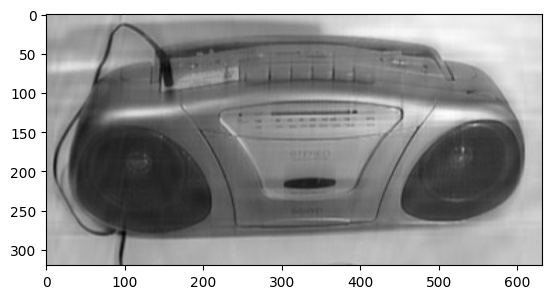

In [ ]:
image_gray = np.mean(np.array(image).astype(float), axis=2)
gray_inverse = remove_freqs(image_gray, 0.01)

plt.imshow(gray_inverse, cmap='gray')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/efficientnetB0_harmonized.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/efficientnetB0_harmonized.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
#make sure running on gpu
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

#import VGG19 model
vgg16 = models.vgg19(weights="IMAGENET1K_V1").to(device)
vgg16.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# clean the dataset to remove greyscale images
def clean_data(dataset):
  new_ds = []
  for i in range(len(dataset)):
    image = dataset['validation'][i]["image"]
    image_data = np.array(image)
    if len(image_data.shape) == 3:
      new_ds.append(dataset[i])
  return new_ds


In [ ]:
#assess VGG19 on Imagenette
labels_imagenette = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
imagenette_indices = [0, 217, 482, 491, 497, 566, 569, 571, 574, 701]

preprocess_im = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

def model_pred(outputs, class_labels):

  outputs_imagenette_specific = outputs[0, imagenette_indices]
  compute = F.softmax(outputs_imagenette_specific, dim=0)
  probability, predicted_class = torch.max(compute, dim=0)
  return str(labels_imagenette[predicted_class.item()])

def load_preprocess(img):
  image_tensor = preprocess_im(img)
  image_tensor.unsqueeze_(0)
  return image_tensor




In [ ]:
from datasets import load_dataset, DatasetDict, Dataset

new_ds = DatasetDict({
    'train': [],
    'validation': [],
})
for i in range(len(ds['validation'])):
  data = ds['validation'][i]
  image = data["image"]
  image_data = np.array(image)
  if len(image_data.shape) == 3:
    new_ds["validation"].append(data)
Dataset.from_list(new_ds["train"])
Dataset.from_list(new_ds["validation"])
print(type(new_ds["validation"][0]))




<class 'dict'>


In [ ]:
vgg16.eval()

# cleaned_data = clean_data(ds)
'''
im = load_preprocess(new_ds["validation"][100]["image"]).to(device)

with torch.no_grad():
  output= vgg16(im)

model_pred(output, labels_imagenette)
'''

correct = 0

for i in range(len(new_ds["validation"])):
  ground_truth = labels_imagenette[new_ds["validation"][i]["label"]]
  im = load_preprocess(new_ds["validation"][i]["image"]).to(device)
  with torch.no_grad():
    output= vgg16(im)
  model_pred(output, labels_imagenette)
  predicted_label = model_pred(output, labels_imagenette)

  if predicted_label == ground_truth:
    correct += 1

accuracy = correct/10

final_acc = accuracy * 100
print(final_acc)


38390.0


In [ ]:
accuracy = correct/len(new_ds["validation"])

final_acc = accuracy * 100
print(final_acc)

99.5591286307054
